<a href="https://colab.research.google.com/github/pwolscho/unet/blob/master/u_net_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![U-Net Demonstration](https://drive.google.com/uc?id=1-kEr1EjJgpSjGCV1oFfYw_A2cnu5cNVI)

#Über dieses Notebook

U-Net ist die bekannteste Architektur im Bereich der Semantischen Segmentierung (Anwendung: Segmentierung in Bildern). Im Rahmen des Kurses Seminat-Deep-Learning der Hochschule Offenburg zeigt dieses Notebook eine mögliche Implementierung von U-Net und demonstriert dessen Anwendung anhand eines Beispiel-Datensatzes.

Informationen zum Datensatz
Mehrere Gebiete der Erde mit großen Öl- und Gasansammlungen haben auch riesige Salzlagerstätten unter der Oberfläche, d.h. dort wo Salz ist, wird vermutlich auch das wertvolle Öl zu finden sein.

Professionelle seismische Messungen zum Auffinden der Salzlagerstätten erfordert immer noch eine fachkundige menschliche Interpretation der daraus resultierenden Bilddaten. Dies führt zu sehr subjektiven, sehr variablen Ergebnissen. Das führt zu potenziell gefährlichen Situationen für Bohrer von Öl- und Gasunternehmen.

Um sehr präzise seismischen Bilder zu erstellen, hofft TGS-NOPEC Geophysical Systems (das weltweit führende Unternehmen für geophysikalische Dienste), dass die Online-Community von Kaggle in der Lage sein wird, einen Algorithmus zu entwickeln, der automatisch und genau erkennt, ob und Salz unter der Erdoberfläche zu finden ist oder nicht.

Dazu wurde im Jahr 2018 eine Wettbewerb von Kaggle durchgeführt.

Auf den diesem Notebook verwendete Datensatz kann nach wie vor unter https://www.kaggle.com/c/tgs-salt-identification-challenge/data zugegriffen werden.

Die Daten sind eine Reihe von seismischen Bildern von zufällig ausgewählten Orten der Erde. Die Bilder sind 101 x 101 Pixel groß und jedes Pixel wird entweder als Salz oder als Sediment klassifiziert. Zusätzlich zu den seismischen Bildern wird für jedes Bild die Tiefe der aufgenommenen Position angegeben.

##Gliederung des Notebooks

Dieses Notebook insgesamt vier individuelle Implementierungen von U-Net. Es werden hauptsächlich das Verhalten folgender U-Net-Modelle untersucht:

- U-Net-Modell Standard (std)
- U-Net-Modell Standard und ohne Skip-Connections (std_no_skip)
- U-Net-Modell mit Data Augmentation (h-flip)
- U-Net-Modell mit Data Augmentation (v-flip)

Die durchgeführten Schritte gliedern sich chronologisch wie folgt:

- Bereitstellung des Datensatzes
- Definition des U-Net-Modells
- Training der U-Net-Modelle
- Evaluierung der U-Net-Modelle

#Bereitstellung des Datensatzes

##Zugriff auf die Kaggle-API

Um auf den Datensatz von Kaggle zugreifen zu können, wird die Kaggle-API (https://www.kaggle.com/docs/api) und einen persönlichen API-Token benötigt. Der API-Token kann im persönlichen Account von Kaggle generiert werden. Um den manuellen Upload (files.upload()) zu umgehen wird der Inhalt des Tokens hartkodiert.

In [0]:
kaggle_json = '{"username":"philipwolschon","key":"715ad801ca6728d6730b7c276db32c6f"}'

Zunächst wird die leere Datei kaggle.json angelegt und mit dem Inhalt des kaggle_json-Objekts (API-Token) befüllt.

In [0]:
import json

In [0]:
with open('kaggle.json', 'w') as file:
  json.dump(kaggle_json, file, ensure_ascii=False)

with open('kaggle.json', 'w') as file:
  file.write(kaggle_json)

Außerdem erwartet die Kaggle-API, dass der API-Token in ~/.kaggle/ (/root/.kaggle/) zu finden ist. Daher wird das Verzeichnis "kaggle" erstellt und der API-Token dort hin verschoben.

In [4]:
!pip install kaggle

In [0]:
# make kaggle directory
!mkdir -p ~/.kaggle

# move the api token
!mv kaggle.json ~/.kaggle/

Liefert folgende Funktion True zurück wurde die erforderliche Datei im korrekten Verzeichnis der VM erstellt (eine manuelle Prüfung ist nicht möglich, da der Zugriff auf das root-Verzeichnis der VM eingeschränkt ist).

In [0]:
import os

In [7]:
# check if api token was created
os.path.isfile("/root/.kaggle/kaggle.json")

True

Um Warnungen beim Starten von Kaggle-Tools zu vermeiden werdem dem Besitzer der Datei Lese- und Schreibrechte gewährt.

In [0]:
!chmod 600 ~/.kaggle/kaggle.json

##Download und Entpacken des Datensatzes

Mit Hilfe der Kaggle-API kann nun das Datenset heruntergeladen werden.

In [9]:
!kaggle competitions download -c tgs-salt-identification-challenge -p /content/salt_data

train.zip: Skipping, found more recently modified local copy (use --force to force download)
depths.csv: Skipping, found more recently modified local copy (use --force to force download)
flamingo.zip: Skipping, found more recently modified local copy (use --force to force download)
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
competition_data.zip: Skipping, found more recently modified local copy (use --force to force download)


Die Trainigsdaten sind komprimiert und müssen zunächst entpackt werden. Zu den Testdaten sind keine Masken vorhanden, weswegen diese nicht weiter verwendet werden.

In [0]:
from zipfile import ZipFile

In [0]:
# just unzip train data
with ZipFile('/content/salt_data/train.zip', 'r') as zipObj:
   zipObj.extractall('/content/salt_data/train')

In [0]:
# save the root path of the training data to use it later in training section
root_train_path = '/content/salt_data/train'

##Skalierung der Trainigsbilder und Masken

In [13]:
import numpy as np
from skimage.transform import resize
from tqdm import tqdm
from keras.preprocessing.image import img_to_array, load_img, array_to_img

Using TensorFlow backend.


Die Methode "get_scaled_images_and_masks" lädt alle persistenten Bilder und Masken aus einem Verzeichnis und skaliert diese auf das gewünschte Format. Eine Skalierung ist nötig, da U-Net lediglich mit Bilder im Format x*x = x^2 umgehen kann.

In [0]:
def get_scaled_images_and_masks(root_train_path, new_img_width, new_img_height):
    print('Getting and resizing images ...')

    # size of the generated output image (rows, columns, dimension)
    output_shape = (new_img_width, new_img_height, 1) 

    # get list of names of all input images from image path
    ids = os.listdir(root_train_path + '/images')

    # get new arrays of given shape and type, filled with zeros
    X = np.zeros((len(ids), new_img_height, new_img_width, 1), dtype=np.float32)
    y = np.zeros((len(ids), new_img_height, new_img_width, 1), dtype=np.float32)
    
    # iterate through all images and masks and do resize operations
    for n, id_ in tqdm(enumerate(ids), total=len(ids)):

        # loads images and masks into PIL format
        imgs = load_img(root_train_path + '/images/' + id_, color_mode = "grayscale")
        masks = load_img(root_train_path + '/masks/' + id_, color_mode = "grayscale")

        # converts PIL images and masks instance to Numpy arrays
        imgs_np = img_to_array(imgs)
        masks_np = img_to_array(masks)

        # resize images and masks to the output shape an keep the original
        # range of values
        imgs_np_rz = resize(imgs_np, output_shape, mode='constant', preserve_range=True)        
        masks_np_rz = resize(masks_np, output_shape, mode='constant', preserve_range=True)

        # divide rgb value by 255 to get floating point value
        X[n, ..., 0] = imgs_np_rz.squeeze() / 255
        y[n] = masks_np_rz / 255

    print('Done!')    
    
    return X, y

Für die Bildgröße wird 128x128x1 gewählt, da diese dem Format entspricht, mit dem U-Net umgehen kann.

In [0]:
img_width = 128
img_height = 128
dimension = 1

In [16]:
# get all images and corresponding masks
X, y = get_scaled_images_and_masks(root_train_path, img_width, img_height)

Getting and resizing images ...


100%|██████████| 4000/4000 [00:13<00:00, 289.67it/s]

Done!


#Definition des U-Net-Netzwerks

##Evaluierungsmetrik

Als Evaluierungsmetrik wird Intersection over Union (IoU) gewählt. Die Tensorflow-Bibliothek stellt diese inkl. Loss-Funktion zur Verfügung.

In [0]:
import tensorflow as tf
from keras import backend as K

In [0]:
def mean_iou(y_true, y_pred):
    # list of precission values 
    prec = []

    # list of IoU thresholds
    thresholds = np.arange(0.5, 1.0, 0.025)

    # calculate mean IoU and loss for prediction
    for threshold in thresholds:
        y_pred_ = tf.cast(y_pred > threshold, tf.int32)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())

        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)

        prec.append(score)

    # return loss and mean IoU
    return K.mean(K.stack(prec), axis=0)

##Architektur

In [0]:
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.optimizers import Adam

In [0]:
def conv2d_block(input_img, n_filters, kernel_size=3, batchnorm=True):
    # first layer
    x = Conv2D(filters=n_filters, 
               kernel_size=(kernel_size, kernel_size), 
               kernel_initializer="he_normal",
               padding="same")(input_img)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    # second layer
    x = Conv2D(filters=n_filters, 
               kernel_size=(kernel_size, kernel_size), 
               kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

In [0]:
def get_unet(input_img, n_filters = 16, dropout= 0.5, batchnorm = True, use_skip_connections = True):

    # contracting path

    # 128 -> 64
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout*0.5)(p1)

    # 64 -> 32
    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    # 32 -> 16
    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    # 16 -> 8
    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)
    
    # middle
    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3, batchnorm=batchnorm)
    
    # expansive path

    # 8 -> 16
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (c5)
    if use_skip_connections == True:
        u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    # 16 -> 32
    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    if use_skip_connections == True:
      u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    # 32 -> 64
    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    if use_skip_connections == True:
      u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    # 64 -> 128
    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    if use_skip_connections == True:
      u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[input_img], outputs=[outputs])
    return model

In [22]:
input_img = Input((128, 128, 1), name='img')

# get u-net-model
model_std = get_unet(
    input_img, 
    n_filters=16, 
    dropout=0.05, 
    batchnorm=True, 
    use_skip_connections = True)

model_std_no_skip = get_unet(
    input_img, 
    n_filters=16, 
    dropout=0.05, 
    batchnorm=True, 
    use_skip_connections = False)

model_h_flip = get_unet(
    input_img, 
    n_filters=16, 
    dropout=0.05, 
    batchnorm=True, 
    use_skip_connections = True)

model_v_flip = get_unet(
    input_img, 
    n_filters=16, 
    dropout=0.05, 
    batchnorm=True, 
    use_skip_connections = True)

# compile u-net-model
model_std.compile(
    optimizer=Adam(), 
    loss="binary_crossentropy", 
    metrics=[mean_iou])

model_std_no_skip.compile(
    optimizer=Adam(), 
    loss="binary_crossentropy", 
    metrics=[mean_iou])

model_h_flip.compile(
    optimizer=Adam(), 
    loss="binary_crossentropy", 
    metrics=[mean_iou])

model_v_flip.compile(
    optimizer=Adam(), 
    loss="binary_crossentropy", 
    metrics=[mean_iou])

model_std.summary()













Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]        

#Training der U-Net-Modelle

## Plot-Funktionen

In [0]:
import matplotlib.pyplot as plt

In [0]:
def plot_learning_curve(fit_results):
    plt.figure(figsize=(8, 8))
    plt.title("Learning curve")
    plt.plot(fit_results.history["loss"], label="loss")
    plt.plot(fit_results.history["val_loss"], label="val_loss")
    plt.plot( np.argmin(fit_results.history["val_loss"]), np.min(fit_results.history["val_loss"]), marker="x", color="r", label="best model")
    plt.xlabel("Epochs")
    plt.ylabel("log_loss")
    plt.legend();

##Data Augmentation

In [0]:
# Importing necessary functions 
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 

In [0]:
def get_image_mask_generator(X, y, do_horizontal_flip = False, do_vertical_flip = False, seed = 1234, batch_size = 32):
    
    # define dictionary with data augmentation settings
    data_gen_args = {
        "horizontal_flip" : do_horizontal_flip, 
        "vertical_flip" : do_vertical_flip}

    # generate batches of tensor image data with real-time data augmentation
    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    # takes image & mask arrays, generate batches of augmented data
    image_generator = image_datagen.flow(X, seed=seed, batch_size = batch_size, shuffle = True)
    mask_generator = mask_datagen.flow(y, seed=seed, batch_size = batch_size, shuffle = True)

    # zip the two generators to get a generator that provides augmented images and masks at the same time
    image_mask_generator = zip(image_generator, mask_generator)

    return image_mask_generator

##Daten in Train, Valid und Test aufteilen

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
random_state_seed_tv_t = 1234
random_state_seed_t_v_t = 2345

# Split X and y into random train_valid and test
X_train_valid, X_test, y_train_valid, y_test = train_test_split(
    X, 
    y, 
    test_size = 0.10, 
    random_state = random_state_seed_tv_t)

# Split X_train_valid and y_train_valid into random train and valid
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_valid, 
    y_train_valid, 
    test_size = 0.222, 
    random_state = random_state_seed_t_v_t)

##U-Net-Modell ohne Data Augmentation (std)

In [0]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [0]:
# EarlyStopping arguments
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ReduceLROnPlateau arguments
# factor              factor by which the learning rate will be reduced
#                     new_lr = lr * factor
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# min_lr              lower bound on the learning rate
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ModelCheckpoint arguments
# filepath            path to save the model file
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch
# save_best_only      if save_best_only=True, the latest best model according 
#                     to the quantity monitored will not be overwritten
# save_weights_only   if True, then only the model's weights will be saved

filepath_std = 'model_std.h5'

callbacks_std = [
    EarlyStopping(
        patience=10, 
        verbose=1),
    ReduceLROnPlateau(
        factor=0.1, 
        patience=3, 
        min_lr=0.000001, 
        verbose=1),
    ModelCheckpoint(
        filepath_std, 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True)
]

In [31]:
# fit arguments
# x                 input data
# y                 target data
# batch_size        number of samples that will be propagated through the network
#                   (take the first batch_size samples from the training set and
#                   train the network, next, take the second batch_size_samples)
# epochs            number of epochs to train the model(an epoch is an iteration
#                   over the entire x and y data provided)
# callbacks         list of Callback instances to applay during training and
#                   validation
# validation_data   data on which to evaluate the loss and any model metrics at 
#                   the end of each epoch

batch_size_std = 32
epochs_std = 100

results_std = model_std.fit(
    X_train, 
    y_train, 
    batch_size=batch_size_std, 
    epochs=epochs_std, 
    callbacks=callbacks_std,
    validation_data=(X_valid, y_valid))



Train on 2800 samples, validate on 800 samples
Epoch 1/100
2800/2800 [==============================] - 19s 7ms/step - loss: 0.5058 - mean_iou: 0.5052 - val_loss: 0.5660 - val_mean_iou: 0.6051

Epoch 00001: val_loss improved from inf to 0.56596, saving model to model_std.h5
Epoch 2/100
2800/2800 [==============================] - 9s 3ms/step - loss: 0.3419 - mean_iou: 0.6286 - val_loss: 0.3214 - val_mean_iou: 0.6393

Epoch 00002: val_loss improved from 0.56596 to 0.32139, saving model to model_std.h5
Epoch 3/100
2800/2800 [==============================] - 9s 3ms/step - loss: 0.2861 - mean_iou: 0.6508 - val_loss: 0.2855 - val_mean_iou: 0.6578

Epoch 00003: val_loss improved from 0.32139 to 0.28549, saving model to model_std.h5
Epoch 4/100
2800/2800 [==============================] - 9s 3ms/step - loss: 0.2551 - mean_iou: 0.6667 - val_loss: 0.3555 - val_mean_iou: 0.6735

Epoch 00004: val_loss did not improve from 0.28549
Epoch 5/100
2800/2800 [==============================] - 9s 3ms/

In [0]:
import matplotlib.pyplot as plt

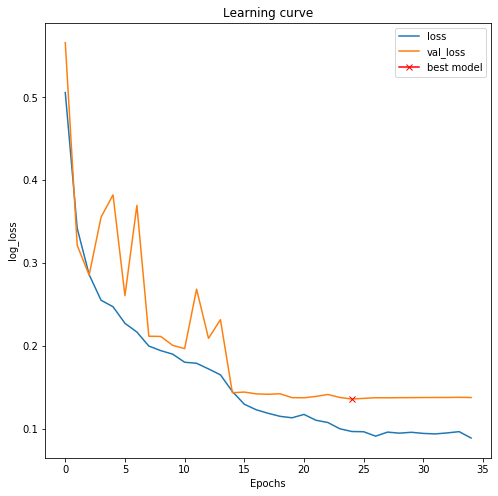

In [33]:
plot_learning_curve(results_std)

##U-Net-Modell ohne Data Augmentation und ohne Skip-Connections (std_no_skip)

In [0]:
# EarlyStopping arguments
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ReduceLROnPlateau arguments
# factor              factor by which the learning rate will be reduced
#                     new_lr = lr * factor
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# min_lr              lower bound on the learning rate
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ModelCheckpoint arguments
# filepath            path to save the model file
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch
# save_best_only      if save_best_only=True, the latest best model according 
#                     to the quantity monitored will not be overwritten
# save_weights_only   if True, then only the model's weights will be saved

filepath_std_no_skip = 'model_std_no_skip.h5'

callbacks_std_no_skip = [
    EarlyStopping(
        patience=10, 
        verbose=1),
    ReduceLROnPlateau(
        factor=0.1, 
        patience=3, 
        min_lr=0.000001, 
        verbose=1),
    ModelCheckpoint(
        filepath_std_no_skip, 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True)
]

In [35]:
# fit arguments
# x                 input data
# y                 target data
# batch_size        number of samples that will be propagated through the network
#                   (take the first batch_size samples from the training set and
#                   train the network, next, take the second batch_size_samples)
# epochs            number of epochs to train the model(an epoch is an iteration
#                   over the entire x and y data provided)
# callbacks         list of Callback instances to applay during training and
#                   validation
# validation_data   data on which to evaluate the loss and any model metrics at 
#                   the end of each epoch

batch_size_std_no_skip = batch_size_std
epochs_std_no_skip = epochs_std

results_std_no_skip = model_std_no_skip.fit(
    X_train, 
    y_train, 
    batch_size=batch_size_std_no_skip, 
    epochs=epochs_std_no_skip, 
    callbacks=callbacks_std_no_skip,
    validation_data=(X_valid, y_valid))

Train on 2800 samples, validate on 800 samples
Epoch 1/100
2800/2800 [==============================] - 16s 6ms/step - loss: 0.4597 - mean_iou: 0.4479 - val_loss: 0.4168 - val_mean_iou: 0.5296

Epoch 00001: val_loss improved from inf to 0.41681, saving model to model_std_no_skip.h5
Epoch 2/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.3177 - mean_iou: 0.5715 - val_loss: 0.8232 - val_mean_iou: 0.5927

Epoch 00002: val_loss did not improve from 0.41681
Epoch 3/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.2882 - mean_iou: 0.6037 - val_loss: 0.6217 - val_mean_iou: 0.6137

Epoch 00003: val_loss did not improve from 0.41681
Epoch 4/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.2537 - mean_iou: 0.6253 - val_loss: 0.2800 - val_mean_iou: 0.6361

Epoch 00004: val_loss improved from 0.41681 to 0.27999, saving model to model_std_no_skip.h5
Epoch 5/100
2800/2800 [==============================] - 8s 3ms/step - loss: 0.2434 

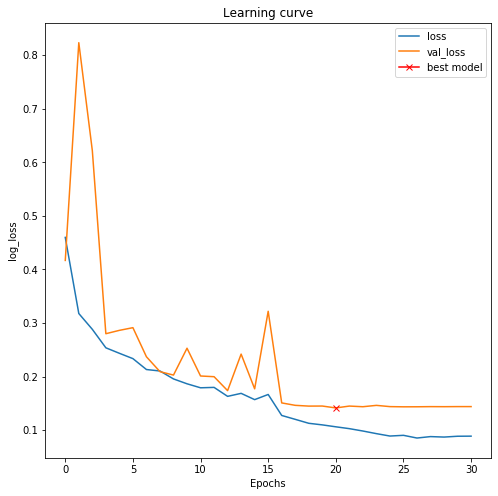

In [36]:
plot_learning_curve(results_std_no_skip)

##U-Net-Modell mit Data Augmentation (h-Flip)

In [0]:
# EarlyStopping arguments
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ReduceLROnPlateau arguments
# factor              factor by which the learning rate will be reduced
#                     new_lr = lr * factor
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# min_lr              lower bound on the learning rate
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ModelCheckpoint arguments
# filepath            path to save the model file
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch
# save_best_only      if save_best_only=True, the latest best model according 
#                     to the quantity monitored will not be overwritten
# save_weights_only   if True, then only the model's weights will be saved

filepath_h_flip = 'model_h_flip.h5'

callbacks_h_flip = [
    EarlyStopping(
        patience = 10, 
        verbose = 1),
    ReduceLROnPlateau(
        factor = 0.1, 
        patience = 3, 
        min_lr = 0.000001, 
        verbose = 1),
    ModelCheckpoint(
        filepath_h_flip, 
        verbose = 1, 
        save_best_only = True, 
        save_weights_only = True)
]

In [0]:
# set seed to be able to reproduce results
seed_h_flip = 1234
batch_size_h_flip = batch_size_std

train_generator_h_flip = get_image_mask_generator(
    X_train, 
    y_train, 
    do_horizontal_flip = True, 
    do_vertical_flip = False, 
    seed = seed_h_flip, 
    batch_size = batch_size_h_flip)

In [39]:
# fit_generator arguments
# generator         train generator
# steps_per_epoch   total number of steps (batches of samples) to yield from
#                   generator before declaring one epoch finished and starting 
#                   the next epoch
# epochs            number of epochs to train the model(an epoch is an iteration
#                   over the entire x and y data provided)
# callbacks         list of Callback instances to applay during training and
#                   validation
# validation_data   data on which to evaluate the loss and any model metrics at 
#                   the end of each epoch

steps_per_epoch_h_flip = (len(X_train) // batch_size_h_flip)
epochs_h_flip = epochs_std

results_h_flip = model_h_flip.fit_generator(
    train_generator_h_flip, 
    steps_per_epoch = steps_per_epoch_h_flip, 
    epochs = epochs_h_flip,
    callbacks = callbacks_h_flip,
    validation_data = (X_valid, y_valid))

Epoch 1/100
87/87 [==============================] - 18s 206ms/step - loss: 0.4281 - mean_iou: 0.5358 - val_loss: 1.1149 - val_mean_iou: 0.6033

Epoch 00001: val_loss improved from inf to 1.11490, saving model to model_h_flip.h5
Epoch 2/100
87/87 [==============================] - 9s 101ms/step - loss: 0.3105 - mean_iou: 0.6158 - val_loss: 0.7340 - val_mean_iou: 0.6303

Epoch 00002: val_loss improved from 1.11490 to 0.73400, saving model to model_h_flip.h5
Epoch 3/100
87/87 [==============================] - 9s 101ms/step - loss: 0.2742 - mean_iou: 0.6404 - val_loss: 0.4645 - val_mean_iou: 0.6498

Epoch 00003: val_loss improved from 0.73400 to 0.46453, saving model to model_h_flip.h5
Epoch 4/100
87/87 [==============================] - 9s 101ms/step - loss: 0.2565 - mean_iou: 0.6581 - val_loss: 0.2951 - val_mean_iou: 0.6651

Epoch 00004: val_loss improved from 0.46453 to 0.29506, saving model to model_h_flip.h5
Epoch 5/100
87/87 [==============================] - 9s 100ms/step - loss: 

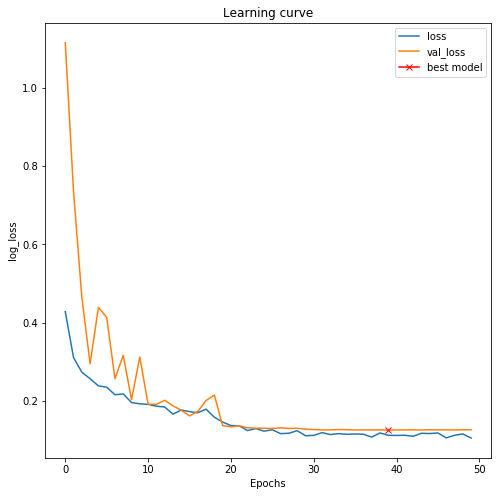

In [40]:
plot_learning_curve(results_h_flip)

##U-Net-Modell mit Data Augmentation (v-Flip)

In [0]:
# EarlyStopping arguments
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ReduceLROnPlateau arguments
# factor              factor by which the learning rate will be reduced
#                     new_lr = lr * factor
# patience            number of epochs that produced the monitored quantity with
#                     no improvement after which training will be stopped
# min_lr              lower bound on the learning rate
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch

# ModelCheckpoint arguments
# filepath            path to save the model file
# verbose             0 = silent, 1 = progress bar, 2 = one line per epoch
# save_best_only      if save_best_only=True, the latest best model according 
#                     to the quantity monitored will not be overwritten
# save_weights_only   if True, then only the model's weights will be saved

filepath_v_flip = 'model_v_flip.h5'

callbacks_v_flip = [
    EarlyStopping(
        patience = 10, 
        verbose = 1),
    ReduceLROnPlateau(
        factor = 0.1, 
        patience = 3, 
        min_lr = 0.000001, 
        verbose = 1),
    ModelCheckpoint(
        filepath_v_flip, 
        verbose = 1, 
        save_best_only = True, 
        save_weights_only = True)
]

In [0]:
seed_v_flip = seed_h_flip
batch_size_v_flip = batch_size_h_flip

train_generator_v_flip = get_image_mask_generator(
    X_train, 
    y_train, 
    do_horizontal_flip = False, 
    do_vertical_flip = True, 
    seed = seed_v_flip, 
    batch_size = batch_size_v_flip)

In [43]:
# fit_generator arguments
# generator         train generator
# steps_per_epoch   total number of steps (batches of samples) to yield from
#                   generator before declaring one epoch finished and starting 
#                   the next epoch
# epochs            number of epochs to train the model(an epoch is an iteration
#                   over the entire x and y data provided)
# callbacks         list of Callback instances to applay during training and
#                   validation
# validation_data   data on which to evaluate the loss and any model metrics at 
#                   the end of each epoch

steps_per_epoch_v_flip = (len(X_train) // batch_size_v_flip)
epochs_v_flip = epochs_std

results_v_flip = model_v_flip.fit_generator(
    train_generator_v_flip, 
    steps_per_epoch = steps_per_epoch_v_flip, 
    epochs = epochs_v_flip,
    callbacks = callbacks_v_flip,
    validation_data = (X_valid, y_valid))

Epoch 1/100
87/87 [==============================] - 19s 214ms/step - loss: 0.4891 - mean_iou: 0.4649 - val_loss: 1.6810 - val_mean_iou: 0.4988

Epoch 00001: val_loss improved from inf to 1.68098, saving model to model_v_flip.h5
Epoch 2/100
87/87 [==============================] - 9s 102ms/step - loss: 0.3655 - mean_iou: 0.5011 - val_loss: 0.5999 - val_mean_iou: 0.5251

Epoch 00002: val_loss improved from 1.68098 to 0.59989, saving model to model_v_flip.h5
Epoch 3/100
87/87 [==============================] - 9s 102ms/step - loss: 0.3342 - mean_iou: 0.5410 - val_loss: 0.4929 - val_mean_iou: 0.5531

Epoch 00003: val_loss improved from 0.59989 to 0.49291, saving model to model_v_flip.h5
Epoch 4/100
87/87 [==============================] - 9s 101ms/step - loss: 0.3212 - mean_iou: 0.5621 - val_loss: 0.3341 - val_mean_iou: 0.5714

Epoch 00004: val_loss improved from 0.49291 to 0.33408, saving model to model_v_flip.h5
Epoch 5/100
87/87 [==============================] - 9s 101ms/step - loss: 

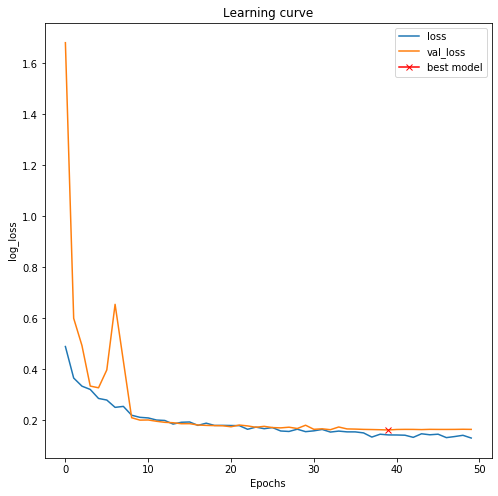

In [44]:
plot_learning_curve(results_v_flip)

#Evaluation der U-Net-Modelle

##Plot-Funktionen

In [0]:
import random

In [0]:
def plot_sample(X, y, preds, binary_preds, ix = None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    fig.suptitle("\n".join(["Sample no.: % 2d" %(ix)]), y=0.75)

    # input
    ax[0].imshow(X[ix, ..., 0], cmap = 'gray')
    ax[0].set_title('Input')

    # ground truth
    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Ground truth')

    # predicted
    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='red', levels=[0.5])
    ax[2].set_title('Predicted')
    
    # predicted binary
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='red', levels=[0.5])
    ax[3].set_title('Predicted binary');

In [0]:
def plot_thresholds(thresholds, threshold_best, ious, iou_best):
    plt.plot(thresholds, ious)
    plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
    plt.xlabel("Threshold")
    plt.ylabel("IoU")
    plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
    plt.legend()

##Threshold-Optimierung

In [0]:
from tqdm import tqdm_notebook

In [0]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(
        labels.flatten(), 
        y_pred.flatten(), 
        bins = (true_objects, pred_objects))[0]

    # compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # compute union
    union = area_true + area_pred - intersection

    # exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # compute the intersection over union
    iou = intersection / union

    # precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

##U-Net-Modell ohne Data Augmentation (std)

###Evaluation

In [0]:
# load best model
model_std.load_weights(filepath_std)

In [51]:
# evaluate on train set
model_std_eva_train = model_std.evaluate(X_train, y_train, verbose=1)

2800/2800 [==============================] - 4s 2ms/step


In [52]:
# evaluate on validation set
model_std_eva_valid = model_std.evaluate(X_valid, y_valid, verbose=1)

800/800 [==============================] - 1s 2ms/step


In [53]:
# evaluate on test set
model_std_eva_test = model_std.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [54]:
# predict on train, val and test
preds_train_std = model_std.predict(X_train, verbose=1)
preds_val_std = model_std.predict(X_valid, verbose=1)
preds_test_std = model_std.predict(X_test, verbose=1)

400/400 [==============================] - 0s 684us/step


###Threshold-Optimierung

In [55]:
# set thresholds to test with predictions
thresholds_std = np.linspace(0, 1 ,50)

# calculate IoUs for each threshold
ious_std = np.array(
    [iou_metric_batch(y_valid, np.int32(preds_val_std > threshold)) 
    for threshold in tqdm_notebook(thresholds_std)])

In [0]:
# get index ob best threshold
threshold_best_index_std = np.argmax(ious_std[9:-10]) + 9

# get best IoU from all calculated IoUs
iou_best_std = ious_std[threshold_best_index_std]

# get best value of threshold
threshold_best_std = thresholds_std[threshold_best_index_std]

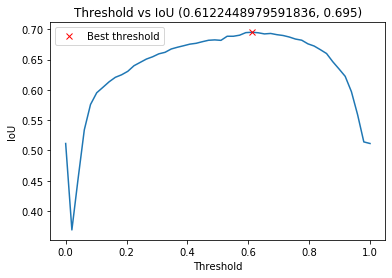

In [57]:
plot_thresholds(thresholds_std, 
                threshold_best_std, 
                ious_std, iou_best_std)

In [0]:
# get binary prediction with optimized thresholds
preds_train_t_std = (preds_train_std > threshold_best_std).astype(np.uint8)
preds_val_t_std = (preds_val_std > threshold_best_std).astype(np.uint8)
preds_test_t_std = (preds_test_std > threshold_best_std).astype(np.uint8)

###Beispielhafte Ausgabe der Vorhersagen

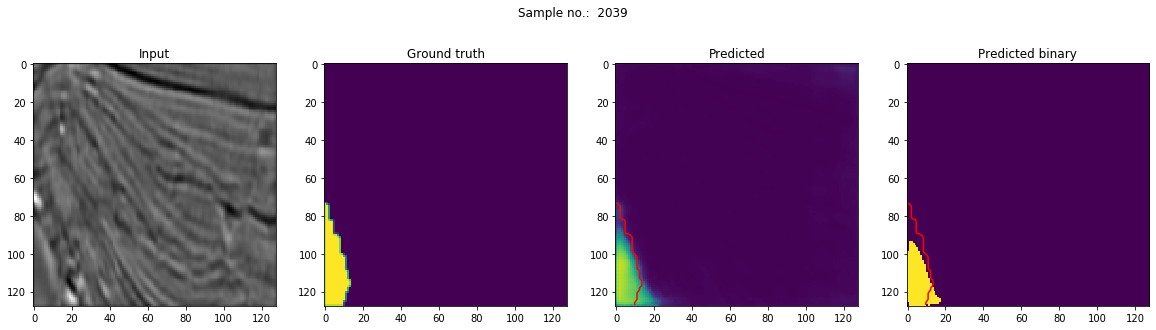

In [77]:
# check if training data looks all right
plot_sample(X_train, y_train, preds_train_std, preds_train_t_std)

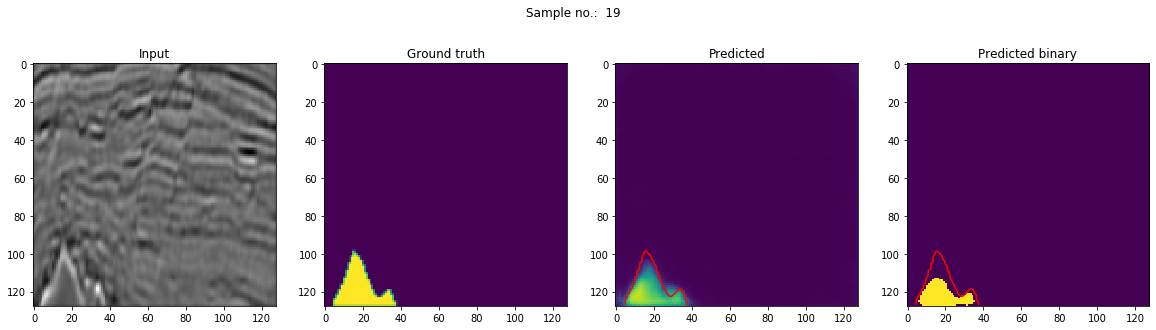

In [79]:
# check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val_std, preds_val_t_std)

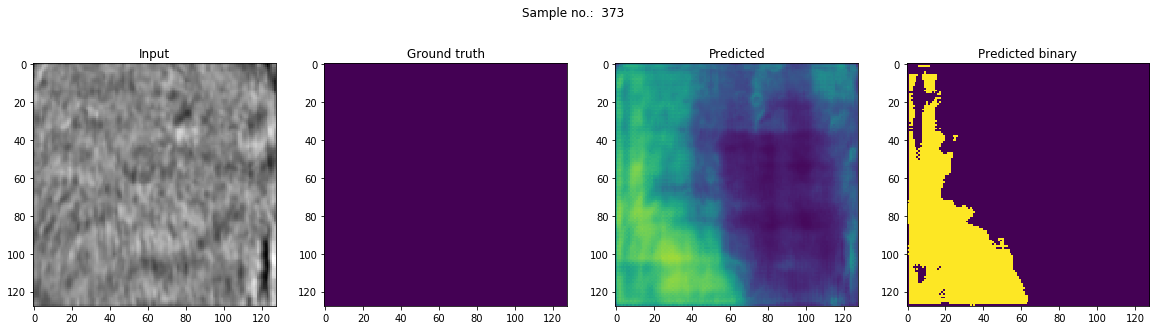

In [80]:
# check if valid data looks all right
plot_sample(X_test, y_test, preds_test_std, preds_test_t_std)

##U-Net-Modell ohne Data Augmentation und ohne Skip-Connections (std_no_skip)

###Evaluation

In [0]:
# Load best model
model_std_no_skip.load_weights(filepath_std_no_skip)

In [82]:
# Evaluate on train set (this must be equals to the best log_loss)
model_std_no_skip_eva_train = model_std_no_skip.evaluate(X_train, y_train, verbose=1)

2800/2800 [==============================] - 4s 2ms/step


In [83]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_std_no_skip_eva_valid = model_std_no_skip.evaluate(X_valid, y_valid, verbose=1)

800/800 [==============================] - 1s 2ms/step


In [84]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_std_no_skip_eva_test = model_std_no_skip.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [85]:
# Predict on train, val and test
preds_train_std_no_skip = model_std_no_skip.predict(X_train, verbose=1)
preds_val_std_no_skip = model_std_no_skip.predict(X_valid, verbose=1)
preds_test_std_no_skip = model_std_no_skip.predict(X_test, verbose=1)

400/400 [==============================] - 0s 644us/step


###Threshold-Optimierung

In [86]:
thresholds_std_no_skip = np.linspace(0, 1 ,50)

ious_std_no_skip = np.array([iou_metric_batch(y_valid, np.int32(preds_val_std_no_skip > threshold)) for threshold in tqdm_notebook(thresholds_std_no_skip)])

In [0]:
threshold_best_index_std_no_skip = np.argmax(ious_std_no_skip[9:-10]) + 9
iou_best_std_no_skip = ious_std_no_skip[threshold_best_index_std_no_skip]
threshold_best_std_no_skip = thresholds_std_no_skip[threshold_best_index_std_no_skip]

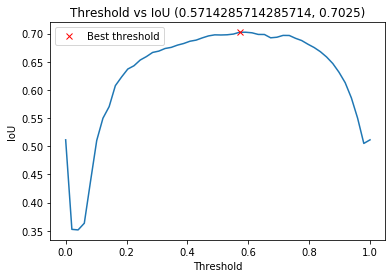

In [88]:
plot_thresholds(thresholds_std_no_skip, threshold_best_std_no_skip, ious_std_no_skip, iou_best_std_no_skip)

In [0]:
# Threshold predictions
preds_train_t_std_no_skip = (preds_train_std_no_skip > threshold_best_std_no_skip).astype(np.uint8)
preds_val_t_std_no_skip = (preds_val_std_no_skip > threshold_best_std_no_skip).astype(np.uint8)
preds_test_t_std_no_skip = (preds_test_std_no_skip > threshold_best_std_no_skip).astype(np.uint8)

###Beispielhafte Ausgabe der Vorhersagen

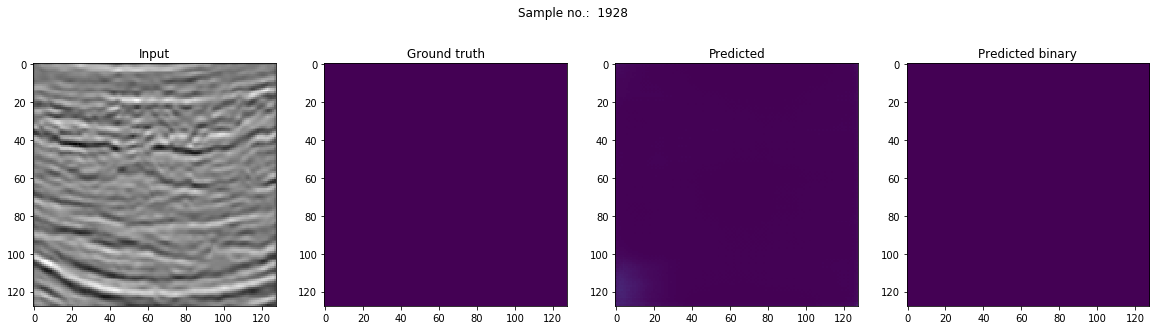

In [90]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train_std_no_skip, preds_train_t_std_no_skip)

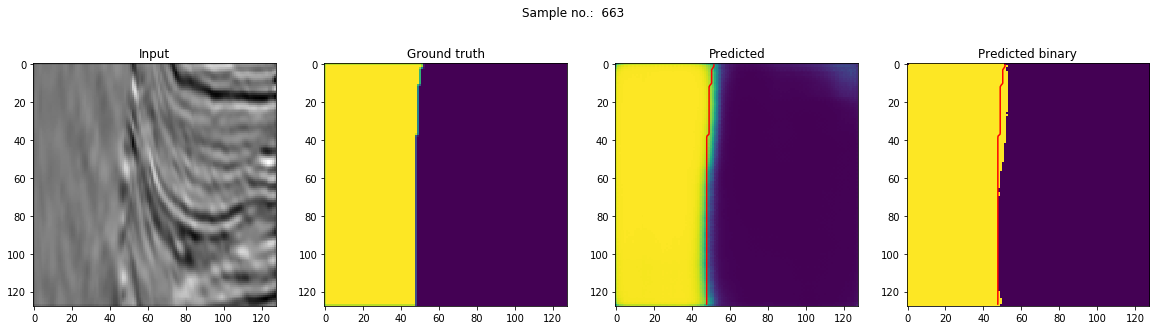

In [91]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val_std_no_skip, preds_val_t_std_no_skip)

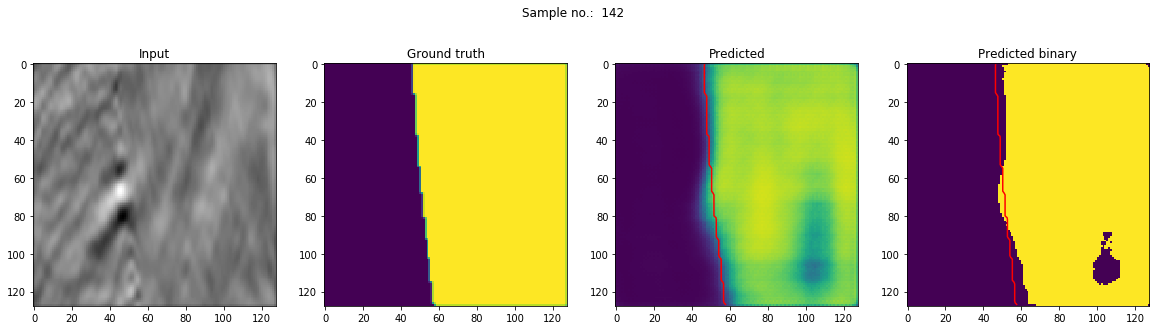

In [92]:
# Check if valid data looks all right
plot_sample(X_test, y_test, preds_test_std_no_skip, preds_test_t_std_no_skip)

##U-Net-Modell mit Data Augmentation (h-Flip)

###Evaluation

In [0]:
# Load best model
model_h_flip.load_weights(filepath_h_flip)

In [94]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_h_flip_eva_train = model_h_flip.evaluate(X_train, y_train, verbose=1)

2800/2800 [==============================] - 4s 2ms/step


In [95]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_h_flip_eva_valid = model_h_flip.evaluate(X_valid, y_valid, verbose=1)

800/800 [==============================] - 1s 2ms/step


In [96]:
# Evaluate on test set (this must be equals to the best log_loss)
model_h_flip_eva_test = model_h_flip.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [97]:
# Predict on train, val and test
preds_train_h_flip = model_h_flip.predict(X_train, verbose=1)
preds_val_h_flip = model_h_flip.predict(X_valid, verbose=1)
preds_test_h_flip = model_h_flip.predict(X_test, verbose=1)

400/400 [==============================] - 0s 674us/step


###Threshold-Optimierung

In [0]:
thresholds_h_flip = np.linspace(0, 1 ,50)

In [99]:
ious_h_flip = np.array([iou_metric_batch(y_valid, np.int32(preds_val_h_flip > threshold)) for threshold in tqdm_notebook(thresholds_h_flip)])
threshold_best_index_h_flip = np.argmax(ious_h_flip[9:-10]) + 9
iou_best_h_flip = ious_h_flip[threshold_best_index_h_flip]
threshold_best_h_flip = thresholds_h_flip[threshold_best_index_h_flip]

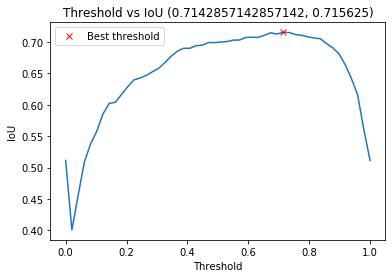

In [100]:
plot_thresholds(thresholds_h_flip, threshold_best_h_flip, ious_h_flip, iou_best_h_flip)

In [0]:
# Threshold predictions
preds_train_h_flip_t = (preds_train_h_flip > threshold_best_h_flip).astype(np.uint8)
preds_val_h_flip_t = (preds_val_h_flip > threshold_best_h_flip).astype(np.uint8)
preds_test_h_flip_t = (preds_test_h_flip > threshold_best_h_flip).astype(np.uint8)

###Beispielhafte Ausgabe der Vorhersagen

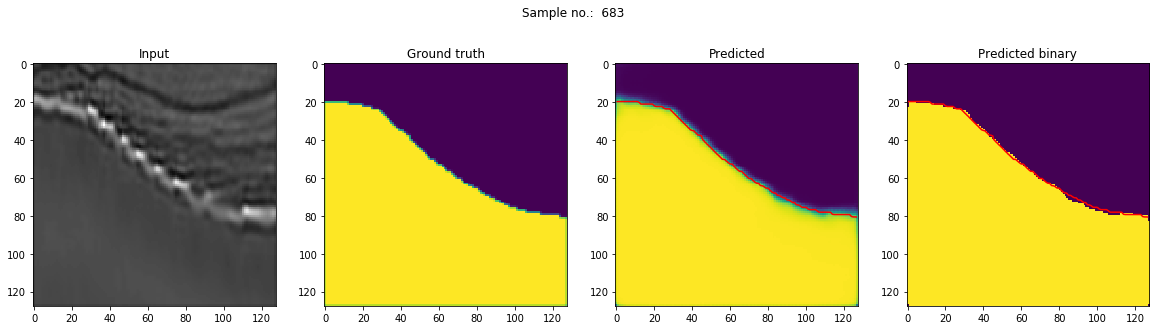

In [102]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train_h_flip, preds_train_h_flip_t, ix = 683)

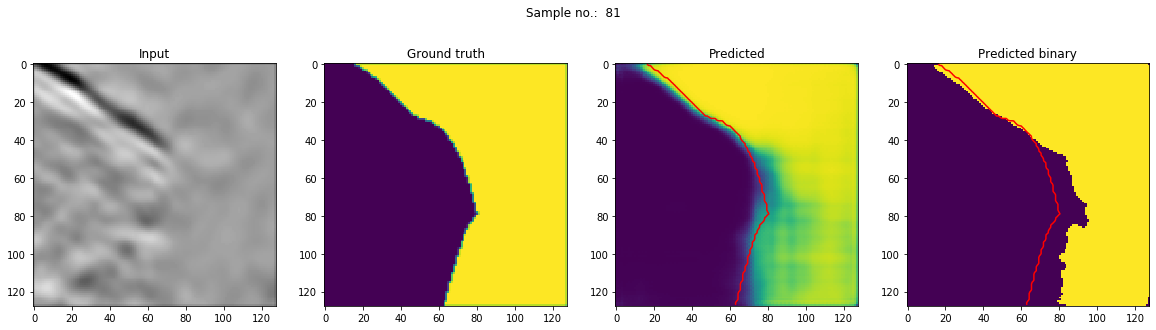

In [103]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val_h_flip, preds_val_h_flip_t, ix = 81)

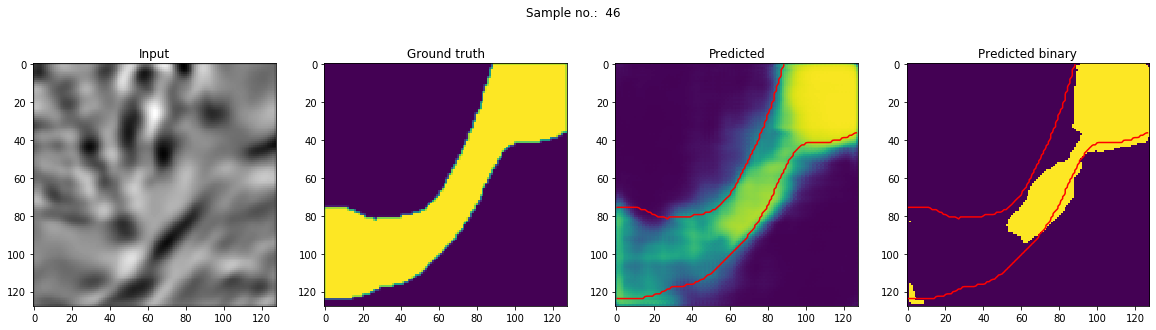

In [104]:
# Check if test data looks all right
plot_sample(X_test, y_test, preds_test_h_flip, preds_test_h_flip_t, ix = 46)

##U-Net-Modell mit Data Augmentation (v-Flip)

###Evaluation

In [0]:
# Load best model
model_v_flip.load_weights(filepath_v_flip)

In [106]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_v_flip_eva_train = model_v_flip.evaluate(X_train, y_train, verbose=1)

2800/2800 [==============================] - 5s 2ms/step


In [107]:
# Evaluate on validation set (this must be equals to the best log_loss)
model_v_flip_eva_valid = model_v_flip.evaluate(X_valid, y_valid, verbose=1)

800/800 [==============================] - 1s 2ms/step


In [108]:
# Evaluate on test set (this must be equals to the best log_loss)
model_v_flip_eva_test = model_v_flip.evaluate(X_test, y_test, verbose=1)

400/400 [==============================] - 1s 2ms/step


In [109]:
# Predict on train, val and test
preds_train_v_flip = model_v_flip.predict(X_train, verbose=1)
preds_val_v_flip = model_v_flip.predict(X_valid, verbose=1)
preds_test_v_flip = model_v_flip.predict(X_test, verbose=1)

400/400 [==============================] - 0s 665us/step


###Threshold-Optimierung

In [0]:
thresholds_v_flip = np.linspace(0, 1 ,50)

In [111]:
ious_v_flip = np.array([iou_metric_batch(y_valid, np.int32(preds_val_v_flip > threshold)) for threshold in tqdm_notebook(thresholds_v_flip)])
threshold_best_index_v_flip = np.argmax(ious_v_flip[9:-10]) + 9
iou_best_v_flip = ious_v_flip[threshold_best_index_v_flip]
threshold_best_v_flip = thresholds_v_flip[threshold_best_index_v_flip]

In [0]:
# Threshold predictions
preds_train_v_flip_t = (preds_train_v_flip > threshold_best_v_flip).astype(np.uint8)
preds_val_v_flip_t = (preds_val_v_flip > threshold_best_v_flip).astype(np.uint8)
preds_test_v_flip_t = (preds_test_v_flip > threshold_best_v_flip).astype(np.uint8)

###Beispielhafte Ausgabe der Vorhersagen

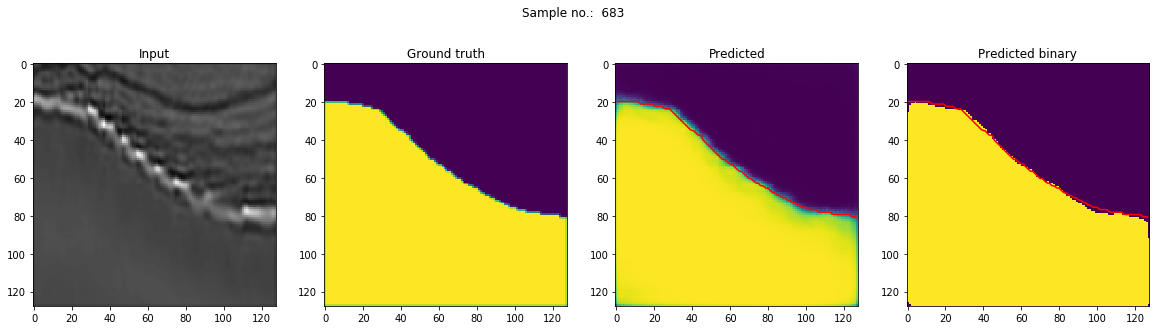

In [113]:
# Check if training data looks all right
plot_sample(X_train, y_train, preds_train_v_flip, preds_train_v_flip_t, ix = 683)

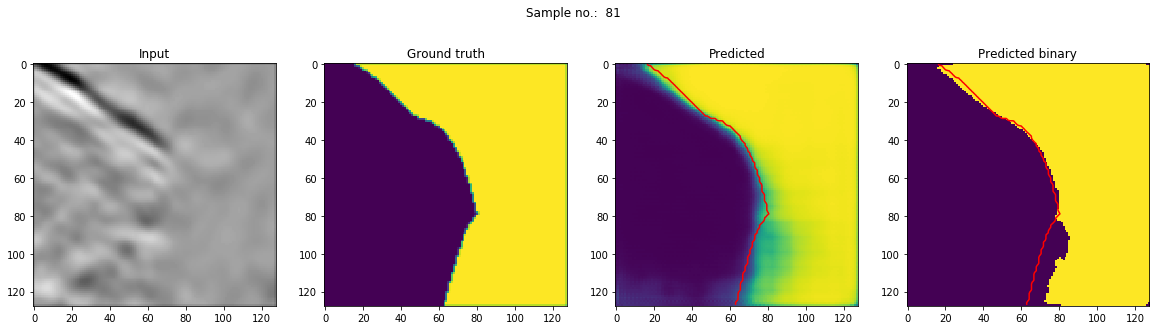

In [114]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val_v_flip, preds_val_v_flip_t, ix = 81)

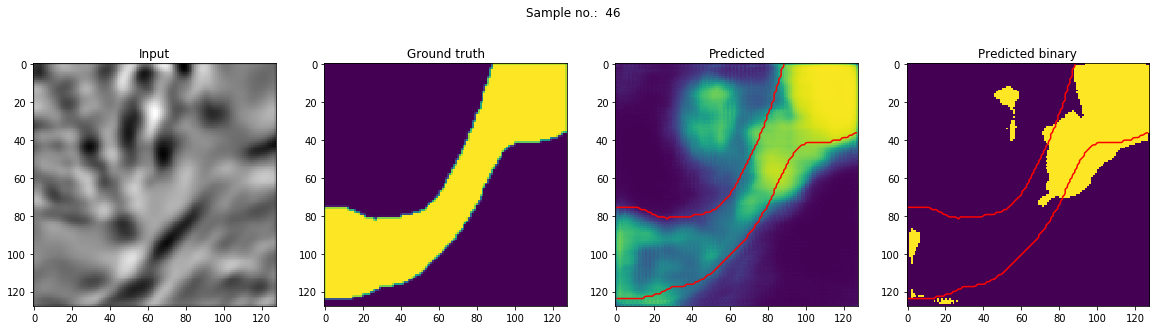

In [115]:
# Check if test data looks all right
plot_sample(X_test, y_test, preds_test_v_flip, preds_test_v_flip_t, ix = 46)

##Vergleich der U-Net-Modelle

In [116]:
pip install beautifultable

In [0]:
from beautifultable import BeautifulTable

In [118]:
table_train = BeautifulTable()
table_train.column_headers = ["U-Net-Model", model_std.metrics_names[0], model_std.metrics_names[1]]
table_train.append_row(["std", model_std_eva_train[0], model_std_eva_train[1]])
table_train.append_row(["std_no_skip", model_std_no_skip_eva_train[0], model_std_no_skip_eva_train[1]])
table_train.append_row(["h-flip", model_h_flip_eva_train[0], model_h_flip_eva_train[1]])
table_train.append_row(["v-flip", model_v_flip_eva_train[0], model_v_flip_eva_train[1]])
print(table_train)

+-------------+-------+----------+
| U-Net-Model | loss  | mean_iou |
+-------------+-------+----------+
|     std     | 0.08  |  0.804   |
+-------------+-------+----------+
| std_no_skip | 0.088 |  0.788   |
+-------------+-------+----------+
|   h-flip    |  0.1  |  0.803   |
+-------------+-------+----------+
|   v-flip    | 0.13  |  0.761   |
+-------------+-------+----------+


In [119]:
table_valid = BeautifulTable()
table_valid.column_headers = ["U-Net-Model", model_std.metrics_names[0], model_std.metrics_names[1]]
table_valid.append_row(["std", model_std_eva_valid[0], model_std_eva_valid[1]])
table_valid.append_row(["std_no_skip", model_std_no_skip_eva_valid[0], model_std_no_skip_eva_valid[1]])
table_valid.append_row(["h-flip", model_h_flip_eva_valid[0], model_h_flip_eva_valid[1]])
table_valid.append_row(["v-flip", model_v_flip_eva_valid[0], model_v_flip_eva_valid[1]])
print(table_valid)

+-------------+-------+----------+
| U-Net-Model | loss  | mean_iou |
+-------------+-------+----------+
|     std     | 0.136 |  0.805   |
+-------------+-------+----------+
| std_no_skip | 0.141 |  0.789   |
+-------------+-------+----------+
|   h-flip    | 0.125 |  0.803   |
+-------------+-------+----------+
|   v-flip    | 0.162 |  0.762   |
+-------------+-------+----------+


In [120]:
table_test = BeautifulTable()
table_test.column_headers = ["U-Net-Model", model_std.metrics_names[0], model_std.metrics_names[1]]
table_test.append_row(["std", model_std_eva_test[0], model_std_eva_test[1]])
table_test.append_row(["std_no_skip", model_std_no_skip_eva_test[0], model_std_no_skip_eva_test[1]])
table_test.append_row(["h-flip", model_h_flip_eva_test[0], model_h_flip_eva_test[1]])
table_test.append_row(["v-flip", model_v_flip_eva_test[0], model_v_flip_eva_test[1]])
print(table_test)

+-------------+-------+----------+
| U-Net-Model | loss  | mean_iou |
+-------------+-------+----------+
|     std     | 0.156 |  0.805   |
+-------------+-------+----------+
| std_no_skip | 0.153 |  0.789   |
+-------------+-------+----------+
|   h-flip    | 0.13  |  0.803   |
+-------------+-------+----------+
|   v-flip    | 0.166 |  0.762   |
+-------------+-------+----------+


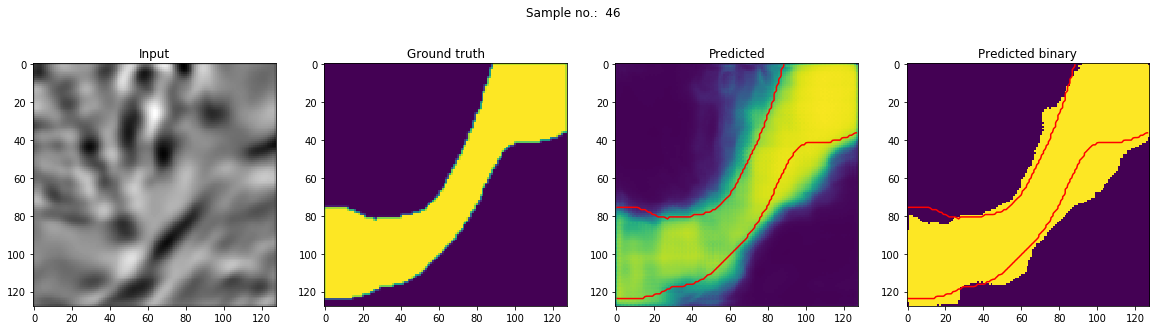

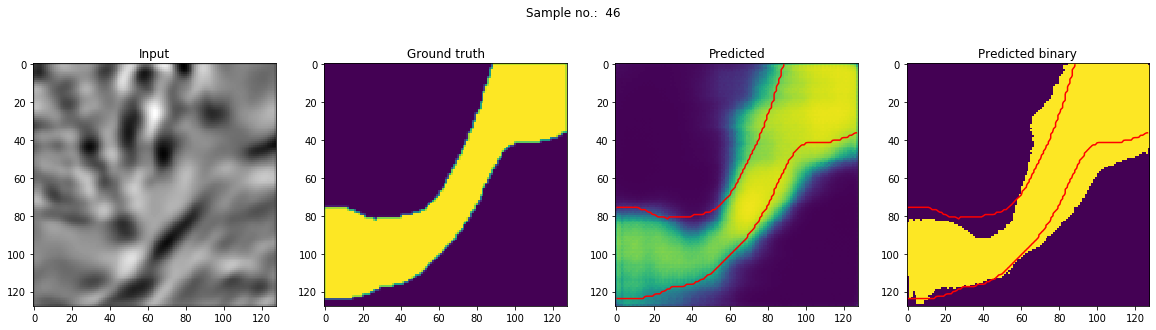

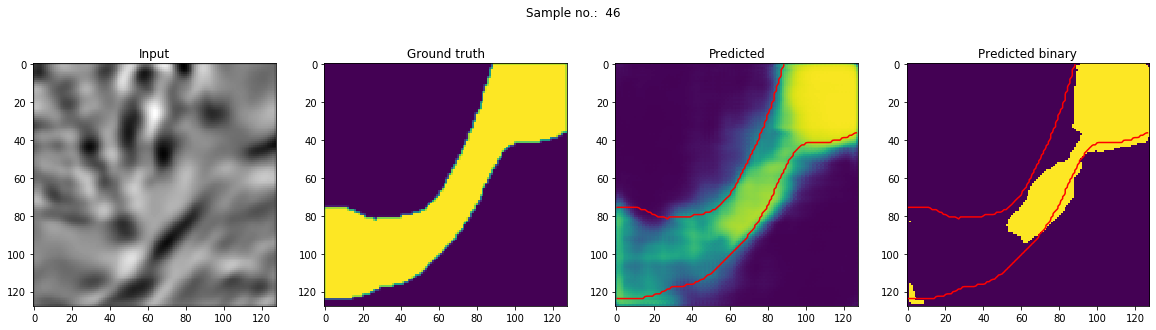

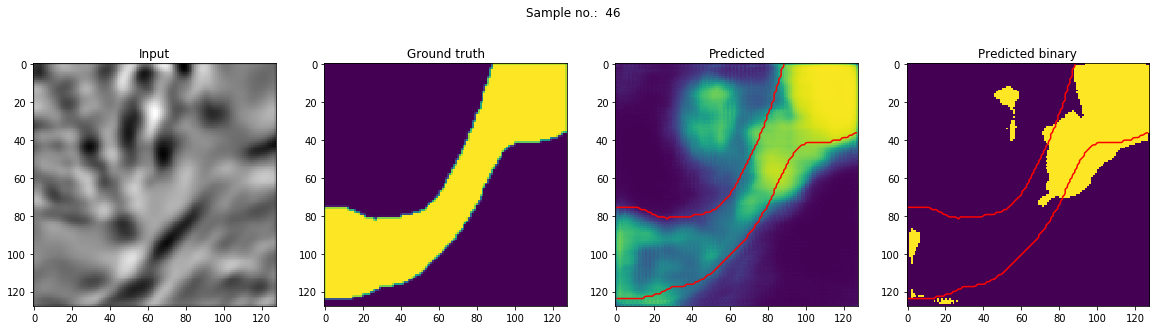

In [121]:
x = 46

plot_sample(X_test, y_test, preds_test_std, preds_test_t_std, ix = x)
plot_sample(X_test, y_test, preds_test_std_no_skip, preds_test_t_std_no_skip, ix = x)
plot_sample(X_test, y_test, preds_test_h_flip, preds_test_h_flip_t, ix = x)
plot_sample(X_test, y_test, preds_test_v_flip, preds_test_v_flip_t, ix = x)

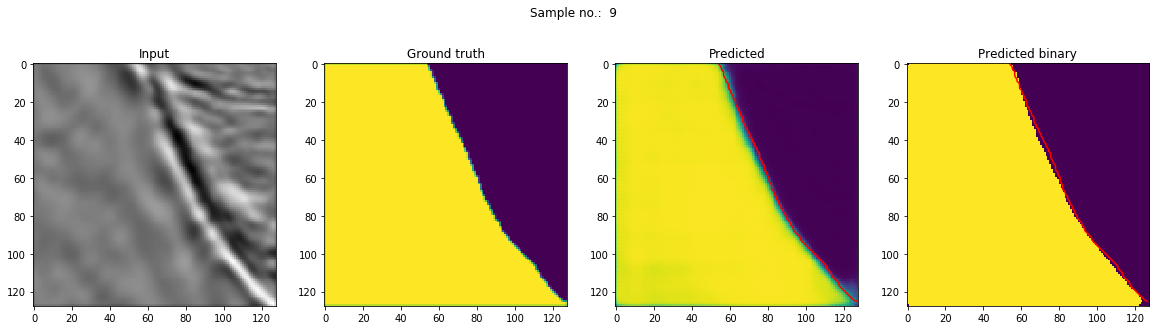

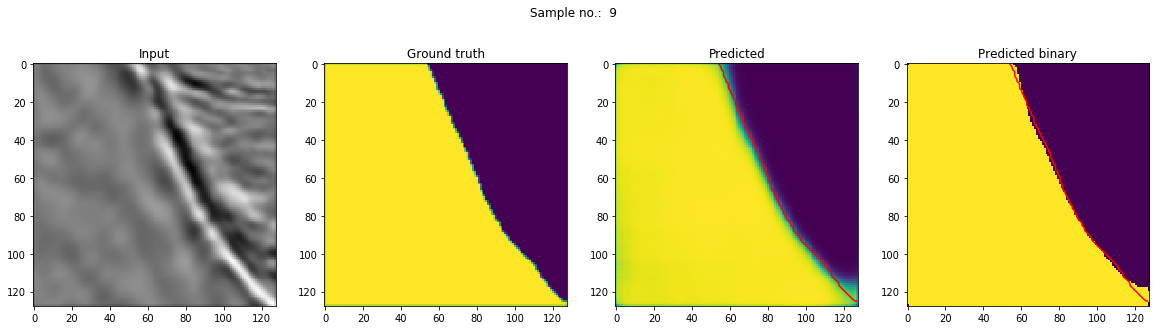

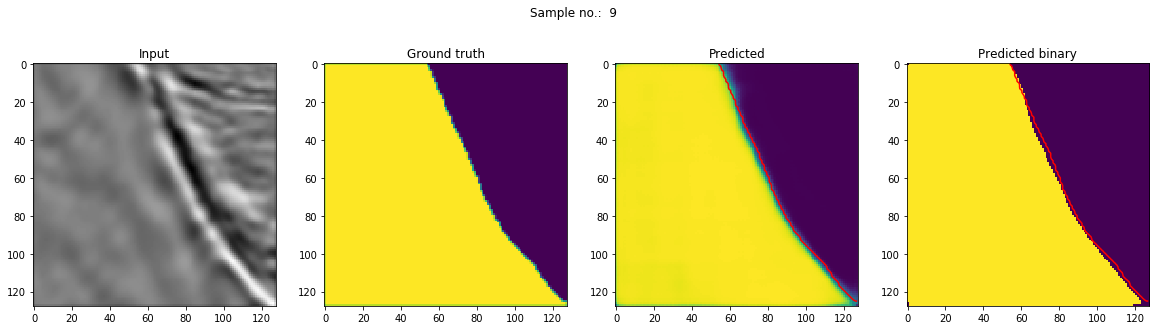

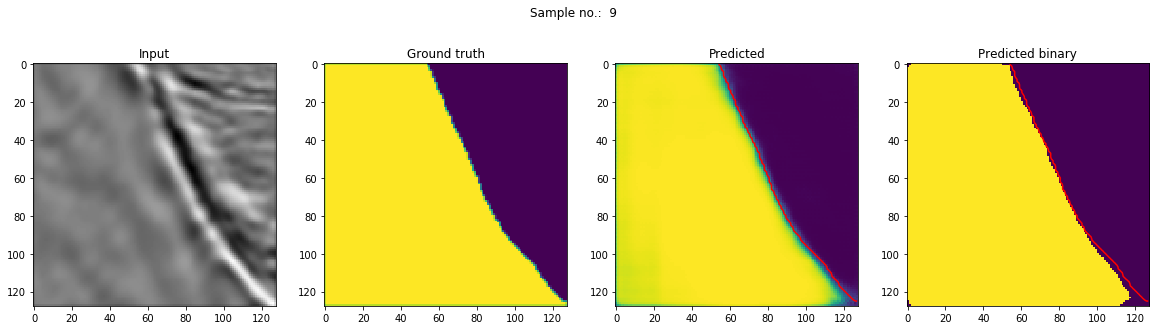

In [122]:
x = 9

plot_sample(X_test, y_test, preds_test_std, preds_test_t_std, ix = x)
plot_sample(X_test, y_test, preds_test_std_no_skip, preds_test_t_std_no_skip, ix = x)
plot_sample(X_test, y_test, preds_test_h_flip, preds_test_h_flip_t, ix = x)
plot_sample(X_test, y_test, preds_test_v_flip, preds_test_v_flip_t, ix = x)